### 최종 조건문 결합

In [ ]:
### 중복의 경우 높은 신뢰도(conf)를 기준으로 남긴다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install ultralytics  # install
from ultralytics import YOLO, checks, hub
checks()  # checks
hub.login('20c4e61161d5c50d7da2643400fe7c7d2105b20855')

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/225.8 GB disk)
Ultralytics HUB: New authentication successful ✅


True

In [ ]:
import cv2
import torch
from torchvision.ops import nms
from PIL import Image
from ultralytics.engine.predictor import BasePredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops
from ultralytics.utils import ASSETS
from ultralytics.models.yolo.detect import DetectionPredictor
import torch
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [ ]:
# 모델 로드
model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0522_t_vis_ensemble/runs/detect/train/weights/best.pt')
model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model_thermal/runs/detect/train/weights/best.pt')


## 이미지 테스트

In [ ]:
# 이미지 경로


#(공중에서 작은사람 5명, 6명)
# rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/test/images/flight3_frame17341.jpg'
# ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/test/images/flight3_frame17341.jpg'

#천막에 가려진 사람 1,3명
rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/train/images/flight3_frame11161.jpg'
ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg'

In [ ]:
import cv2
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt

import torch
from torchvision.ops import nms

def predict_rgb(image_path):
    """RGB 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    rgb_results = model_rgb.predict(image_path, conf=0.5)[0]  # model_rgb는 RGB 이미지를 처리하는 모델
    return rgb_results.boxes.data

def predict_ir(image_path):
    """IR 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    ir_results = model_ir.predict(image_path, conf=0.5)[0]  # model_ir는 IR 이미지를 처리하는 모델
    return ir_results.boxes.data

# def combine_results(rgb_results, ir_results):
#     """두 결과의 바운딩 박스 정보를 결합하고 중복을 제거합니다."""
#     # 두 결과의 바운딩 박스 정보를 결합
#     combined_boxes = torch.cat([rgb_results, ir_results])
#     # NMS로 중복 제거
#     keep = nms(combined_boxes[:, :4], combined_boxes[:, 4], iou_threshold=0.5)  # conf_thres는 실제 NMS 함수에 사용되지 않음
#     final_boxes = combined_boxes[keep]
#     return final_boxes

def resize_image(image_path, target_size=(640, 640)):
    """이미지를 리사이징하고, 리사이징된 이미지와 비율을 반환합니다."""
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    scale_x = target_size[1] / w
    scale_y = target_size[0] / h
    return resized_image, scale_x, scale_y

def adjust_boxes(boxes, scale_x, scale_y):
    """바운딩 박스의 크기를 이미지의 리사이징 비율에 맞게 조정합니다."""
    adjusted_boxes = boxes.clone()
    adjusted_boxes[:, 0] *= scale_x
    adjusted_boxes[:, 2] *= scale_x
    adjusted_boxes[:, 1] *= scale_y
    adjusted_boxes[:, 3] *= scale_y
    return adjusted_boxes

def visualize_boxes(image, boxes):
    """이미지에 바운딩 박스를 그리고 반환합니다."""
    for box in boxes:
        x1, y1, x2, y2, conf = box[:5]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'Conf: {conf:.2f}'
        cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return image

def combine_results(rgb_results, ir_results):
    """결과를 통합하고 NMS를 적용합니다."""
    combined_boxes = torch.cat([rgb_results, ir_results])
    keep = nms(combined_boxes[:, :4], combined_boxes[:, 4], iou_threshold=0.5)
    final_boxes = combined_boxes[keep]
    return final_boxes

def show_images_side_by_side(rgb_image, ir_image):
    """두 이미지를 병렬로 표시합니다."""
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2)

    ax0 = plt.subplot(gs[0])
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    ax0.set_title('RGB Image')

    ax1 = plt.subplot(gs[1])
    plt.imshow(cv2.cvtColor(ir_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    ax1.set_title('IR Image')

    plt.show()


image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/train/images/flight3_frame11161.jpg: 384x640 1 person, 274.6ms
Speed: 6.4ms preprocess, 274.6ms inference, 24.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg: 384x640 3 persons, 580.2ms
Speed: 2.6ms preprocess, 580.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


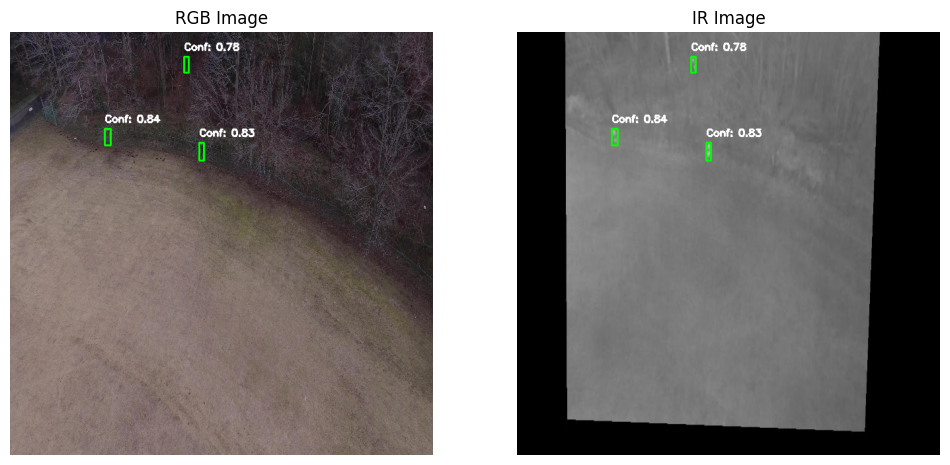

In [ ]:
#rgb ir 둘다 있을때
rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/train/images/flight3_frame11161.jpg'
ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg'

# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### RGB만


image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/test_3.jpg: 480x640 (no detections), 456.9ms
Speed: 4.7ms preprocess, 456.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


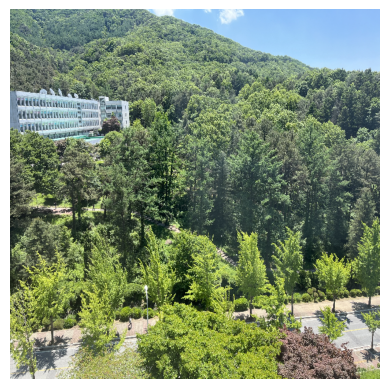

In [ ]:
# RGB만 들어올 경우

# 앙상블모델_visdrone+NII_rgb 학습 로드
#model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/final_vis_NI_Irgb/runs/detect/train/weights/last.pt')

model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0522_t_vis_ensemble/runs/detect/train/weights/best.pt')

#/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0522_t_vis_ensemble/runs/detect/train/weights/best.pt




#(잘됨) -> 기존모델2
#model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0518_vis_1/runs/detect/train2/weights/best.pt')


# 이미지 경로
# rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/test/images/flight3_frame17341.jpg'
rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/test_3.jpg'
#ir_image_path = None

# 이미지와 결과 로드 및 리사이징
# rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
# ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

# rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
# ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')


image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/test_2.jpg: 480x640 1 pedestrian, 16 cars, 513.5ms
Speed: 5.6ms preprocess, 513.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


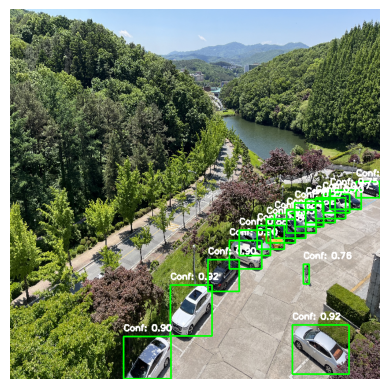

In [ ]:
# RGB만 들어올 경우

# 앙상블모델_visdrone+NII_rgb 로드
#model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/final_vis_NI_Irgb/runs/detect/train/weights/last.pt')

#(잘됨) -> 기존모델2(NII 데이터 학습 X)
model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0518_vis_1/runs/detect/train2/weights/best.pt')


# 이미지 경로
# rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_rgb/test/images/flight3_frame17341.jpg'
rgb_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/test_2.jpg'
ir_image_path = None

# 이미지와 결과 로드 및 리사이징
# rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
# ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

# rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
# ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')

#### IR만


image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg: 384x640 3 persons, 893.8ms
Speed: 8.7ms preprocess, 893.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


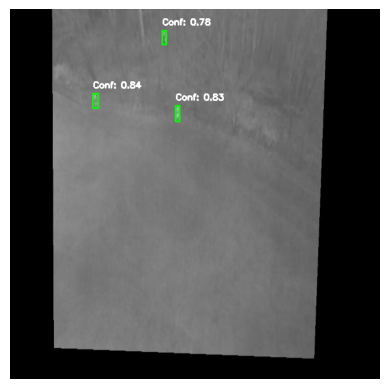

In [ ]:
# IR만 들어올 경우
model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model_thermal/runs/detect/train/weights/best.pt')
# 이미지 경로
rgb_image_path = None
ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg'
#ir_image_path ='/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/ir_test_1.jpg.png'
# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')



image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/test/images/flight3_frame17291.jpg: 384x640 4 persons, 720.1ms
Speed: 3.6ms preprocess, 720.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


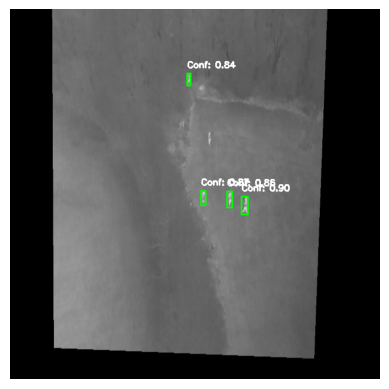

In [ ]:
# IR만 들어올 경우
model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model_thermal/runs/detect/train/weights/best.pt')
#model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0518_vis_1/runs/detect/train2/weights/best.pt')

# 이미지 경로
rgb_image_path = None
ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/test/images/flight3_frame17291.jpg'
#ir_image_path ='/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/ir_test_1.jpg.png'

# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')



image 1/1 /content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/ir_test_2.jpg.png: 480x640 (no detections), 532.8ms
Speed: 4.4ms preprocess, 532.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


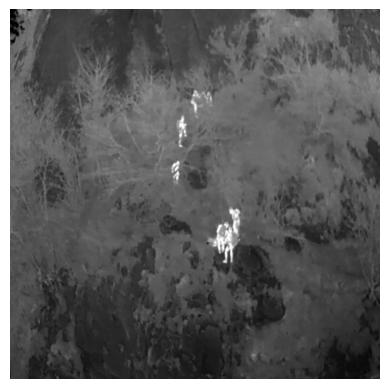

In [ ]:
# IR만 들어올 경우
model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model_thermal/runs/detect/train/weights/best.pt')
# 이미지 경로
rgb_image_path = None
#ir_image_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/each_thermal/train/images/flight3_frame11161.jpg'
ir_image_path ='/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/w/ir_test_2.jpg.png'
# 조건에 따른 출력

if rgb_image_path and ir_image_path:
  # 둘다 이미지 결과 로드 및 리사이징
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)

    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    final_rgb_boxes = combine_results(rgb_results, ir_results)
    final_ir_boxes = combine_results(ir_results, rgb_results)
    rgb_image_with_boxes = visualize_boxes(rgb_image, final_rgb_boxes)
    ir_image_with_boxes = visualize_boxes(ir_image, final_ir_boxes)
    show_images_side_by_side(rgb_image_with_boxes, ir_image_with_boxes)

elif rgb_image_path:
  #rgb만 있을때
    rgb_image, scale_x_rgb, scale_y_rgb = resize_image(rgb_image_path)
    rgb_results = adjust_boxes(predict_rgb(rgb_image_path), scale_x_rgb, scale_y_rgb)

    rgb_image_with_boxes = visualize_boxes(rgb_image, rgb_results)
    plt.imshow(cv2.cvtColor(rgb_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
elif ir_image_path:
  #ir만 있을때
    ir_image, scale_x_ir, scale_y_ir = resize_image(ir_image_path)
    ir_results = adjust_boxes(predict_ir(ir_image_path), scale_x_ir, scale_y_ir)

    ir_image_with_boxes = visualize_boxes(ir_image, ir_results)
    plt.imshow(cv2.cvtColor(ir_image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')


## 영상 테스트

In [ ]:
import cv2
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시를 위한 임포트

# YOLOv8 모델 로드
model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model/runs/detect/train/weights/best.pt')
model_ir = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/model_thermal/runs/detect/train/weights/best.pt')

def predict_rgb(frame):
    """RGB 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    rgb_results = model_rgb.predict(frame, conf=0.5)[0]
    return rgb_results.boxes.data

def predict_ir(frame):
    """IR 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    ir_results = model_ir.predict(frame, conf=0.5)[0]
    return ir_results.boxes.data

def resize_image(frame, target_size=(640, 640)):
    """이미지를 리사이징하고, 리사이징된 이미지와 비율을 반환합니다."""
    h, w = frame.shape[:2]
    resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_LINEAR)
    scale_x = target_size[1] / w
    scale_y = target_size[0] / h
    return resized_frame, scale_x, scale_y

def adjust_boxes(boxes, scale_x, scale_y):
    """바운딩 박스의 크기를 이미지의 리사이징 비율에 맞게 조정합니다."""
    adjusted_boxes = boxes.clone()
    adjusted_boxes[:, 0] *= scale_x
    adjusted_boxes[:, 2] *= scale_x
    adjusted_boxes[:, 1] *= scale_y
    adjusted_boxes[:, 3] *= scale_y
    return adjusted_boxes

def visualize_boxes(frame, boxes):
    """이미지에 바운딩 박스를 그리고 반환합니다."""
    for box in boxes:
        x1, y1, x2, y2, conf = box[:5]
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'Conf: {conf:.2f}'
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return frame

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame, scale_x, scale_y = resize_image(frame)
        rgb_results = adjust_boxes(predict_rgb(resized_frame), scale_x, scale_y)
        frame_with_boxes = visualize_boxes(frame, rgb_results)

        cv2_imshow(frame_with_boxes)  # Colab에서 이미지를 표시하기 위해 cv2_imshow 사용
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
# 비디오 파일 경로 설정
video_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/Drone_Flying_Over_Beach_Full_Of_Tourists_preview.mp4'
process_video(video_path)

In [ ]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시를 위한 임포트

def predict_rgb(frame):
    """RGB 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    rgb_results = model_rgb.predict(frame, conf=0.5)[0]
    return rgb_results.boxes.data

def letterbox_image(image, size=(640, 640)):
    """이미지의 비율을 유지하면서 새로운 크기로 조정하고 패딩을 추가하여 지정된 크기로 만듭니다."""
    ih, iw = image.shape[:2]
    h, w = size
    scale = min(w / iw, h / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_LINEAR)
    new_image = cv2.copyMakeBorder(image_resized, (h-nh)//2, (h-nh)//2, (w-nw)//2, (w-nw)//2, cv2.BORDER_CONSTANT, value=(128,128,128))
    return new_image, scale, (h-nh)//2, (w-nw)//2

def adjust_boxes(boxes, scale, pad_y, pad_x):
    """바운딩 박스의 크기를 이미지의 리사이징 비율 및 패딩에 맞게 조정합니다."""
    adjusted_boxes = boxes.clone()
    adjusted_boxes[:, 0] = (boxes[:, 0] * scale + pad_x).clamp(0)
    adjusted_boxes[:, 1] = (boxes[:, 1] * scale + pad_y).clamp(0)
    adjusted_boxes[:, 2] = (boxes[:, 2] * scale + pad_x).clamp(0)
    adjusted_boxes[:, 3] = (boxes[:, 3] * scale + pad_y).clamp(0)
    return adjusted_boxes

def visualize_boxes(frame, boxes):
    """이미지에 바운딩 박스를 그리고 반환합니다."""
    for box in boxes:
        x1, y1, x2, y2, conf = box[:5]
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'Conf: {conf:.2f}'
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return frame

def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 비디오 코덱 설정
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (640, 640))  # 출력 비디오 설정

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame, scale, pad_y, pad_x = letterbox_image(frame)
        rgb_results = adjust_boxes(predict_rgb(resized_frame), scale, pad_y, pad_x)
        frame_with_boxes = visualize_boxes(resized_frame, rgb_results)

        out.write(frame_with_boxes)  # 프레임을 출력 비디오에 기록

        cv2_imshow(frame_with_boxes)  # 실시간으로 프레임을 표시
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()



In [ ]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시를 위한 임포트


def predict_rgb(resized_frame):
    """리사이즈된 RGB 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    rgb_results = model_rgb.predict(resized_frame, conf=0.3)[0]
    return rgb_results.boxes.data

def letterbox_image(image, size=(640, 640)):
    """이미지의 비율을 유지하면서 새로운 크기로 조정하고 패딩을 추가하여 지정된 크기로 만듭니다."""
    ih, iw = image.shape[:2]
    h, w = size
    scale = min(w / iw, h / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_LINEAR)
    new_image = cv2.copyMakeBorder(image_resized, (h-nh)//2, (h-nh)//2, (w-nw)//2, (w-nw)//2, cv2.BORDER_CONSTANT, value=(128,128,128))
    return new_image, scale, (h-nh)//2, (w-nw)//2

def adjust_boxes(boxes, scale, pad_y, pad_x):
    """바운딩 박스의 크기를 이미지의 리사이징 비율 및 패딩에 맞게 조정합니다."""
    adjusted_boxes = boxes.clone()
    adjusted_boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale + pad_x
    adjusted_boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale + pad_y
    return adjusted_boxes

def visualize_boxes(frame, boxes):
    """이미지에 바운딩 박스를 그리고 반환합니다."""
    for box in boxes:
        x1, y1, x2, y2, conf = box[:5]
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'Conf: {conf:.2f}'
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return frame

def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 비디오 코덱 설정
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (640, 640))  # 출력 비디오 설정

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame, scale, pad_y, pad_x = letterbox_image(frame)
        rgb_results = predict_rgb(resized_frame)
        frame_with_boxes = visualize_boxes(resized_frame, rgb_results)

        out.write(frame_with_boxes)  # 프레임을 출력 비디오에 기록

        cv2_imshow(frame_with_boxes)  # 실시간으로 프레임을 표시
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()



In [ ]:
# 비디오 파일 경로 설정
video_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/Drone_Flying_Over_Beach_Full_Of_Tourists_preview.mp4'
output_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/output.mp4'

# 비디오 처리 및 저장
process_video(video_path, output_path)

# 처리된 비디오 재생
play_video(output_path)


In [ ]:
play_video(output_path)

In [ ]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시를 위한 임포트

# YOLOv8 모델 로드
model_rgb = YOLO('/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/0522_t_vis_ensemble/runs/detect/train/weights/best.pt')

def predict_rgb(resized_frame, conf=0.3):
    """리사이즈된 RGB 이미지에 대해 예측을 수행하고 바운딩 박스를 반환합니다."""
    rgb_results = model_rgb.predict(resized_frame, conf=conf)[0]
    return rgb_results.boxes.data

def letterbox_image(image, size=(640, 640)):
    """이미지의 비율을 유지하면서 새로운 크기로 조정하고 패딩을 추가하여 지정된 크기로 만듭니다."""
    ih, iw = image.shape[:2]
    h, w = size
    scale = min(w / iw, h / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_LINEAR)
    new_image = cv2.copyMakeBorder(image_resized, (h-nh)//2, (h-nh)//2, (w-nw)//2, (w-nw)//2, cv2.BORDER_CONSTANT, value=(128,128,128))
    return new_image, scale, (h-nh)//2, (w-nw)//2

def adjust_boxes(boxes, scale, pad_y, pad_x):
    """바운딩 박스의 크기를 이미지의 리사이징 비율 및 패딩에 맞게 조정합니다."""
    adjusted_boxes = boxes.clone()
    adjusted_boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale + pad_x
    adjusted_boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale + pad_y
    return adjusted_boxes

def visualize_boxes(frame, boxes):
    """이미지에 바운딩 박스를 그리고 반환합니다."""
    for box in boxes:
        x1, y1, x2, y2, conf = box[:5]
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'Conf: {conf:.2f}'
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return frame

def process_video(video_path, output_path, conf=0.3):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 비디오 코덱 설정
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (640, 640))  # 출력 비디오 설정

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        resized_frame, scale, pad_y, pad_x = letterbox_image(frame)
        rgb_results = predict_rgb(resized_frame, conf)
        adjusted_boxes = adjust_boxes(rgb_results, scale, pad_y, pad_x)
        frame_with_boxes = visualize_boxes(resized_frame, adjusted_boxes)

        out.write(frame_with_boxes)  # 프레임을 출력 비디오에 기록
        print(f"Processed frame {frame_count}")

        # cv2_imshow(frame_with_boxes)  # 실시간으로 프레임을 표시 (Colab 환경에서만 사용)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processed {frame_count} frames.")

def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()




In [ ]:
# 비디오 파일 경로 설정
# 비디오 파일 경로 설정
video_path = '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/Drone_Flying_Over_Beach_Full_Of_Tourists_preview.mp4'
output_path =  '/content/drive/MyDrive/Colab Notebooks/2024_1/capstone/drone/rgb-t/output_2.mp4'


# 비디오 처리 및 저장
process_video(video_path, output_path, conf=0.3)

# 처리된 비디오 재생
play_video(output_path)
# 비디오 처리 및 저장
process_video(video_path, output_path, conf=0.3)

# 처리된 비디오 재생
play_video(output_path)


0: 640x640 109 pedestrians, 1 motor, 628.2ms
Speed: 6.9ms preprocess, 628.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 1

0: 640x640 112 pedestrians, 1 motor, 605.0ms
Speed: 2.9ms preprocess, 605.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 2

0: 640x640 118 pedestrians, 1 motor, 614.1ms
Speed: 3.4ms preprocess, 614.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 3

0: 640x640 127 pedestrians, 1 people, 599.0ms
Speed: 2.9ms preprocess, 599.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 4

0: 640x640 126 pedestrians, 3 peoples, 609.2ms
Speed: 2.8ms preprocess, 609.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 5

0: 640x640 127 pedestrians, 2 peoples, 607.8ms
Speed: 2.8ms preprocess, 607.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed frame 6

0: 640x640 108 pedestr